# one node per network

## all
- Total unique paths:         10041
- At least 1 UDP & 1 TCP:     9666  (96.27 %)
- No UDP and at least 1 TCP:  271   (2.7   %)
- No UDP and no tcp:          103   (1.02  %)
- No TCP and at least 1 UDP:  1     (0.01  %)

## 12345 8008 1228
- Total unique paths:          14241  
- At least 1 UDP & 1 TCP:      13671  (96   %)
- No UDP and at least 1 TCP:   442    (3.1  %)
- No UDP and no tcp:           127    (0.89 %)
- No TCP and at least 1 UDP:   1      (0.01 %)

## 1228
- Total unique paths:          14241 
- At least 1 UDP & 1 TCP:      13670 (95.99 %)
- No UDP and at least 1 TCP:   335   (2.35  %)
- No UDP and no tcp:           236   (1.66  %)

## 12345
- Total unique paths:          14241 
- At least 1 UDP & 1 TCP:      12876 (90.41 %)
- No TCP and at least 1 UDP:   675   (4.74  %)
- No UDP and at least 1 TCP:   431   (3.03  %)
- No UDP and no tcp:           259   (1.82  %)

## 8008
- Total unique paths:          14241 
- At least 1 UDP & 1 TCP:      13558 (95.2 %)
- No UDP and at least 1 TCP:   552   (3.88 %)
- No UDP and no tcp:           130   (0.91 %)
- No TCP and at least 1 UDP:   1     (0.01 %)

## 33435
- Total unique paths:          10041
- At least 1 UDP & 1 TCP:      9567  (95.28 %)
- No UDP and at least 1 TCP:   369   (3.67  %)
- No UDP and no tcp:           105   (1.05  %)


# Block Policies

- 139.91.90.239: blocks all ingress TCP/UDP and all egress UDP
- 132.72.23.10 blocks all UDP
 
- 162.105.205.22 blocks all egress UDP
- 162.105.205.22 blocks ingress UDP/12345
- 128.42.142.45 blocks ingress 12345
- 4 nodes blocks ingress TCP/12345
- 2 blocks egress TCP/12345

- 1 nodes blocks egress UDP/8008

- 2 nodes blocks egress UDP/33435
- 1 node blocks ingress 33435
- 1 node blocks ingress UDP/33435

In [1]:
# load connectivity per 4-tuples
import connectivity
import imp
imp.reload(connectivity)

portlist = [1228, 12345, 8008, 33435]
all_cids1=["sch1-0007-t5-f1-1", "sch1-0007-t5-f2-1", "sch1-0007-t5-f1-2", "sch1-0007-t5-f2-2",
          "sch1-0008-t10-f1-1", "sch1-0008-t10-f2-1"]
all_cids2=["sch1-0002-t3-f1-1", "sch1-0002-t3-f1-2", "sch1-0002-t3-f1-3", "sch1-0002-t3-f2-1", 
          "sch1-0002-t3-f2-2", "sch1-0002-t3-f2-3", "sch1-0003-t3-f1-4", "sch1-0003-t3-f2-4"]
all_cids=all_cids1+all_cids2
# Merge connectivity data from all files, adding offset to copycatRunId
# Takes some time...
conn       = None
offset     = 0
offset_inc = 10
for cid in all_cids:
    print(cid)
    if conn is None:
        conn = connectivity.connectivity(cid, run_id_offset=offset)
    else:
        conn = conn.append(connectivity.connectivity(cid, run_id_offset=offset))
    offset += offset_inc

# load bad flows
bad_nodes   = None
offset     = 0
offset_inc = 10
for cid in all_cids:
    print(cid)
    if bad_nodes is None:
        bad_nodes = connectivity.bad_pl_servers(cid, run_id_offset=offset)
    else:
        bad_nodes = bad_nodes.append(connectivity.bad_pl_servers(cid, run_id_offset=offset))
    offset += offset_inc

sch1-0007-t5-f1-1
sch1-0007-t5-f2-1
sch1-0007-t5-f1-2
sch1-0007-t5-f2-2
sch1-0008-t10-f1-1
sch1-0008-t10-f2-1
sch1-0002-t3-f1-1
sch1-0002-t3-f1-2
sch1-0002-t3-f1-3
sch1-0002-t3-f2-1
sch1-0002-t3-f2-2
sch1-0002-t3-f2-3
sch1-0003-t3-f1-4
sch1-0003-t3-f2-4


# connections
-1.0 means UDP client did not receive any UDP response and TCP client received a SYNACK
1.0 means UDP client did receive a UDP response and TCP client did not received a SYNACK
0.0 means both did not receive or both received UDP respone/TCP SYNACK

Note that most TCP connectivity failure are not permanent as shown in previous per-path numbers.

### total 1242601
- 0.0: 94.53%
- -1.0: 3.99%
- 1.0: 1.47%

### port: 1228 rows: 241291
- 0.0: 96.19% (232094)
- -1.0: 3.51% (8475)
- 1.0: 0.30% (722)

### port: 12345 rows: 294928
- 0.0: 91.65% (270310)
- 1.0: 4.82% (14221)
- -1.0: 3.53% (10397)

### port: 8008 rows: 313236
- 0.0: 95.08% (297825)
- -1.0: 4.39% (13749)
- 1.0: 0.53% (1662)

### port: 33435 rows: 393146
- 0.0: 95.24% (374421)
- -1.0: 4.33% (17010)
- 1.0: 0.44% (1715)

In [3]:
# select server nodes that received UDP but did not answer (bug) and don't notify as connectivity problem
ind = ["sourceIPv4Address","destinationIPv4Address", 
       "destinationTransportPort", "copycatRunId"]
nothing_sent = bad_nodes[bad_nodes.connectivity == 0]
nothing_sent = nothing_sent.reset_index().drop_duplicates(ind).set_index(ind)

# isolate bad nodes and set them both to conn (0)
bads=conn[conn.index.isin(nothing_sent.index)].dropna()
bads.connectivity = 8

# select good nodes, drop bad nodes
goods = conn[~conn.index.isin(nothing_sent.index)].dropna()
print(len(bads))
conn = goods

11574


In [14]:
# remove nodes from same subnetworks
import locations

unique_conn = conn.reset_index()
for n in unique_conn.sourceIPv4Address.unique():
    if n not in locations.countries_nb_unique:
        unique_conn = unique_conn[unique_conn.sourceIPv4Address != n]
        
for n in unique_conn.destinationIPv4Address.unique():
    if n not in locations.countries_nb_unique:
        unique_conn = unique_conn[unique_conn.destinationIPv4Address != n]
        
unique_conn = unique_conn.reset_index()
conn = unique_conn

In [101]:
# remove faulty PL nodes (no pcap or all pcap empty or no directory, etc)
nopcap1 = ["192.114.4.3", "192.12.33.102", "150.214.150.187", "200.10.150.252", "138.246.253.3",
         "130.127.39.152", "194.199.68.166", "193.136.227.163", "192.33.193.18", "141.83.148.102",
         "131.188.44.102"] # 33435
nopcap2 = ["203.178.143.10", "194.199.68.166", "138.246.253.1", "193.136.227.163", 
           "130.83.166.245", "138.246.253.3", "132.227.62.99", "141.83.148.102", 
           "131.188.44.102", "150.214.150.187", "131.246.19.202", "203.178.143.28", 
           "141.83.148.101", "192.114.4.3", "192.33.193.18"] # rest

conn = conn.reset_index()
for bad_node in nopcap1:
    conn = conn[(conn.destinationTransportPort != "33435") | ((conn.destinationTransportPort == "33435") & 
                      (conn.sourceIPv4Address != bad_node) & 
                      (conn.destinationIPv4Address != bad_node))]
    
for bad_node in nopcap2:
    conn = conn[(conn.destinationTransportPort == "33435") | ((conn.destinationTransportPort != "33435") & 
                      (conn.sourceIPv4Address != bad_node) & 
                      (conn.destinationIPv4Address != bad_node))]

In [ ]:
# Transpose to 4 states connectivity
import config
# 
# 0 no conn
# 1 is only TCP
# 2 is only TCP
# 3 is both
this_conn = conn
this_conn = this_conn.replace(6,2)
this_conn = this_conn.replace(4,0)

In [119]:
import config
# connection count
# move bitmask space to [-1;1]
# -1 is only TCP
#  1 is only UDP
#  0 is both or none

this_conn = this_conn.replace(1,-1)
this_conn = this_conn.replace(2,1)
#
this_conn = this_conn.replace(3,0)
this_conn = this_conn.replace(4,0)
this_conn = this_conn.reset_index()

# TOTAL
# count occurences of [-1, 0, 1]
#
l = len(this_conn)
print("total %d"%l)

for k,d in this_conn.connectivity.value_counts().items():
    print("%s: %.2f%%" % (k, (float(d)/l)*100))
print() 
# per port
for p in portlist:
    this_p = this_conn[this_conn.destinationTransportPort == str(p)]
    l = len(this_p)
    print("port: %d rows: %d" % (p, l))
    for k,d in this_p.connectivity.value_counts().items():
        print("%s: %.2f%% (%d)" % (k, (float(d)/l)*100, d))
    print()

total 1242601
0.0: 94.53%
-1.0: 3.99%
1.0: 1.47%

port: 1228 rows: 241291
0.0: 96.19% (232094)
-1.0: 3.51% (8475)
1.0: 0.30% (722)

port: 12345 rows: 294928
0.0: 91.65% (270310)
1.0: 4.82% (14221)
-1.0: 3.53% (10397)

port: 8008 rows: 313236
0.0: 95.08% (297825)
-1.0: 4.39% (13749)
1.0: 0.53% (1662)

port: 33435 rows: 393146
0.0: 95.24% (374421)
-1.0: 4.33% (17010)
1.0: 0.44% (1715)



In [ ]:
# mean connectivity status
import template

def filter_conn(l):
    return l.mean()

grouped   = this_conn[["sourceIPv4Address","destinationIPv4Address", "destinationTransportPort", "connectivity"]].groupby(template.index)
this_conn = grouped.agg(filter_conn).dropna().reset_index()
this_conn

In [121]:
# After meaning connectivity bias between runs, print bias per node
better_udp_count = len(this_conn[(this_conn.connectivity > 0.0)])
better_tcp_count = len(this_conn[(this_conn.connectivity < 0.0)])
equal_count      = len(this_conn[this_conn.connectivity == 0.0])
total_count      = len(this_conn)
print("nodes with better UDP conn: %.2f%%\nnodes with better TCP conn: %.2f%%\nrest: %.2f%%" % ((better_udp_count/total_count*100),
                          (better_tcp_count/total_count*100),
                          (equal_count/total_count*100)))


for p in portlist:
    this_p = this_conn[this_conn.destinationTransportPort == str(p)]
    better_udp_count = len(this_p[this_p.connectivity > 0.0])
    better_tcp_count = len(this_p[this_p.connectivity < 0.0])
    equal_count      = len(this_p[this_p.connectivity == 0.0])
    total_count      = len(this_p)
    print(p)
    print("nodes with better UDP conn: %.2f%%\nnodes with better TCP conn: %.2f%%\nrest: %.2f%%" % ((better_udp_count/total_count*100),
                          (better_tcp_count/total_count*100),
                          (equal_count/total_count*100)))


nodes with better UDP conn: 5.68%
nodes with better TCP conn: 16.72%
rest: 77.60%
1228
nodes with better UDP conn: 2.44%
nodes with better TCP conn: 15.20%
rest: 82.36%
12345
nodes with better UDP conn: 8.59%
nodes with better TCP conn: 18.21%
rest: 73.20%
8008
nodes with better UDP conn: 4.92%
nodes with better TCP conn: 19.34%
rest: 75.74%
33435
nodes with better UDP conn: 7.20%
nodes with better TCP conn: 13.07%
rest: 79.73%


In [122]:
set(this_conn.sourceIPv4Address.unique()) ^ set(this_conn.destinationIPv4Address.unique())

{'141.83.148.101'}

In [ ]:
#""" filtering step:
#only keep nodes that have data for src and dst, and more than 50% flows (done at log parsing)
#sourceIPv4Address & destinationIPv4Address must be in nb_countries format (int)
#""" 
def clean_df(df, nb_nodes=220):
   
    
    nodes=sorted(list(set(df.sourceIPv4Address.value_counts().index) 
                      & set(df.destinationIPv4Address.value_counts().index)))
    min_count = nb_nodes * .2
    
    clean_count=0
    for n in range(nb_nodes):
        if n in nodes:
            l2=len(df[df.sourceIPv4Address == n]["destinationIPv4Address"].value_counts())
            if l2 >= min_count:
                clean_count += 1
                continue
                
        df = df[(df.destinationIPv4Address != n) & (df.sourceIPv4Address != n)]       
            
    return df, clean_count

for a in this_conn.sourceIPv4Address.value_counts().index:
    print(len(this_conn[this_conn.sourceIPv4Address == a].destinationIPv4Address.value_counts()))

nodes: 120
nodes: 120
nodes: 120
nodes: 101


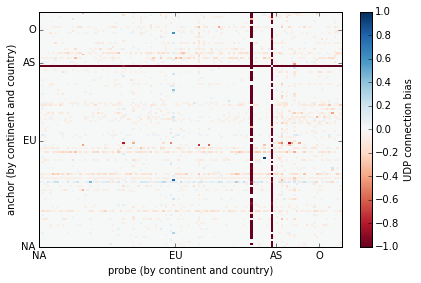

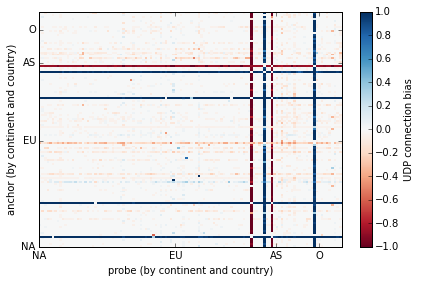

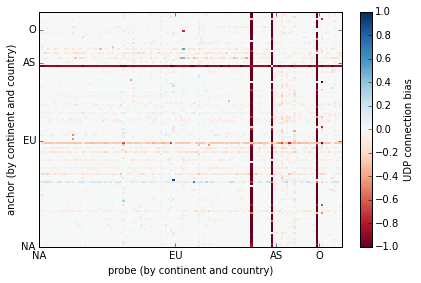

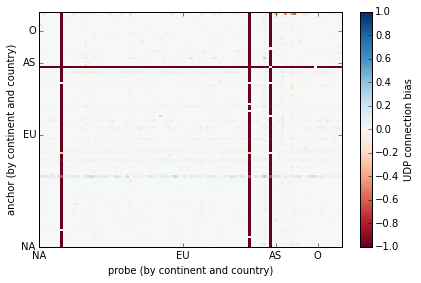

In [130]:
%matplotlib inline
import locations
import imp
import graph, config
import pandas as pd
import pylab as p
import numpy as np
imp.reload(locations)

def grid_index(size):
    l = []
    for e in range(size):
        for f in range(size):
            l.append(e)   
    return l 

def get_continent_index(df):
    """
    returns a continent index tuple    
    (0,95,158,191)
    """
    ind   = [0]
    i     = 1
    c     = 0
    nodes = sorted(list(df.sourceIPv4Address.value_counts().index))
    cont_index = sorted(list(locations.continent_nb.values()))
    
    for n in nodes:
        if i == 4:
            break
        elif n >= cont_index[i]:
            ind.append(c)
            i += 1
        c += 1
    return tuple(ind)

def gridplot(a, label, cmap="RdBu", vrange=None, file=None, title=None, ticks=None, dim=None):
    # gridplot from Brian
    p.figure() 
    if vrange is None:
        p.pcolor(a, cmap=cmap)
    else:
        p.pcolor(a, cmap=cmap, vmin=vrange[0], vmax=vrange[1])
    if dim is not None:
        p.xlim(dim)
        p.ylim(dim)
    if ticks is not None:
        p.xticks(ticks,("NA", "EU", "AS", "O")) 
        p.yticks(ticks,("NA", "EU", "AS", "O")) 
    p.xlabel("probe (by continent and country)")
    p.ylabel("anchor (by continent and country)")
    p.colorbar(label=label)
    if title:
        p.title(title)
    p.tight_layout()
    
for port in portlist:
    port = str(port)
    this_p = this_conn[this_conn.destinationTransportPort == port][["sourceIPv4Address","destinationIPv4Address", "connectivity"]]
    # map addresses
    this_p.sourceIPv4Address      = this_p.sourceIPv4Address.map(locations.countries_nb)
    this_p.destinationIPv4Address = this_p.destinationIPv4Address.map(locations.countries_nb)
    # remove destinations that are not in sources for this port
    nodes=sorted(list(this_p.sourceIPv4Address.value_counts().index))
    for n in range(220):
        if n not in nodes:
            this_p = this_p[this_p.destinationIPv4Address != n]

    this_p, this_dim = clean_df(this_p)
    print("nodes: "+str(this_dim))
    # get anchors continent indexes
    nodes_index = get_continent_index(this_p) 
    this_p = this_p.reset_index(drop=True)
    this_p = this_p.set_index(["destinationIPv4Address", "sourceIPv4Address"])
    this_p = this_p.unstack().fillna(0.0) 
    # title="connectivity bias for port "+port,
    gridplot(this_p, "UDP connection bias",  vrange=[-1.0,1.0], ticks=nodes_index, dim=[0, this_dim])
    p.savefig("plots/conn-loc-"+port+".pdf") 

In [110]:
# mean per nodes, print extreme values
this_p = this_conn[this_conn.destinationTransportPort == "33435"][["sourceIPv4Address","destinationIPv4Address", "connectivity"]]
print("dst")
for d in set(this_p.destinationIPv4Address):
    m = this_p[this_p.destinationIPv4Address == d]["connectivity"].mean()
    if m > 0.1 or m < -0.1:
        print("%.2f %s" % (m, d))
print("src")
for d in set(this_p.sourceIPv4Address):
    m = this_p[this_p.sourceIPv4Address == d]["connectivity"].mean()
    if m > 0.1 or m < -0.1:
        print("%.2f %s" % (m, d))

dst
-1.00 132.72.23.10
-0.13 131.247.2.242
-1.00 143.215.131.198
src
-0.98 132.72.23.10
-0.97 129.10.120.194
-0.98 139.91.90.239
-0.97 129.10.120.193


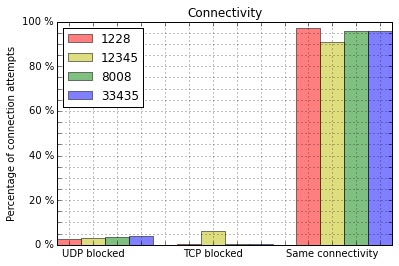

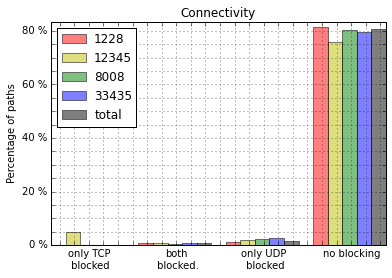

In [105]:
%matplotlib inline
import numpy as np
import pylab as p
# connectivity summaries

# per connection summary
c1228  = (0.0273,0.0032,0.9695)
c12345 = (0.0319,0.0599,0.9082)
c8008 = (0.0364,0.0051,0.9585)
c33435 = (0.0386,0.0043,0.9571)
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 1.0/ 5       # the width of the bars

fig, ax = p.subplots()
rects1 = ax.bar(ind, c1228, width, color='r', alpha=0.5)
rects2 = ax.bar(ind+width, c12345, width, color='y', alpha=0.5)
rects3 = ax.bar(ind+2*width, c8008, width, color='g', alpha=0.5)
rects4 = ax.bar(ind+3*width, c33435, width, color='b', alpha=0.5)
p.grid()

ax.set_ylabel('Percentage of connection attempts')
ax.set_title('Connectivity')
ax.set_xticks([(e/5)+0.1 for e in range(N*5)][:-1])
ax.set_xticklabels( ("","UDP blocked","","","",
                     "","TCP blocked","","","",
                     "","Same connectivity",""))
ax.set_yticks(tuple([float(e/100) for e in range(0,101,5)]))
ax.set_yticklabels(tuple([str(e)+" %" if (e%20==0) else "" for e in range(0,101,5)]))
ax.set_xlim([0,2.8])
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('1228', '12345', '8008', '33435'), loc=2 )
p.savefig("plots/conn-summary1.pdf")
p.show()

# per path summary

c1228  = (0.0001, 0.0097,0.0143,0.9759)
c12345 = (0.0581,0.0111,0.0217,0.9091)
c8008 = (0.0001, 0.0055,0.0287,0.9657)
c33435 = (0.0, 0.0117, 0.0335, 0.9548)
ctotal = (0.0001, 0.0095, 0.0196, 0.9708)

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 1.0/ 6       # the width of the bars

fig, ax = p.subplots()
rects1 = ax.bar(ind, c1228, width, color='r', alpha=0.5)
rects2 = ax.bar(ind+width, c12345, width, color='y', alpha=0.5)
rects3 = ax.bar(ind+2*width, c8008, width, color='g', alpha=0.5)
rects4 = ax.bar(ind+3*width, c33435, width, color='b', alpha=0.5)
rects5 = ax.bar(ind+4*width, ctotal, width, color='k', alpha=0.5)
p.grid()

ax.set_ylabel('Percentage of paths')
ax.set_title('Connectivity')
ax.set_xticks([(e/6)+0.1 for e in range(N*6)][:-1])
ax.set_xticklabels( ("","","only TCP\n blocked","","","","",
                     "","both\n blocked.","","","","","",
                     "only UDP\n blocked","","","","","",
                    "no blocking","","","",))
ax.set_yticks(tuple([float(e/100) for e in range(0,101,6)]))
ax.set_yticklabels(tuple([str(e)+" %" if (e%20==0) else "" for e in range(0,101,5)]))
ax.set_xlim([0,3.83])
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), ('1228', '12345', '8008', '33435', 'total'), loc=2 )
p.savefig("plots/conn-summary2.pdf")
p.show()

# DEAD CODE

In [ ]:
this_port = this_conn[this_conn.destinationTransportPort == "33435"]
aggred = this_port.groupby(["sourceIPv4Address", "destinationIPv4Address"])["connectivity"].agg(block_finder)
print("to")
print(aggred[aggred == 1].reset_index().destinationIPv4Address.value_counts())
print("from")
print(aggred[aggred == 1].reset_index().sourceIPv4Address.value_counts())

# connectivity with raw datasets

Port 33435

Total connection attempts:     1195011
Successful or failed for both: 1143675 (95.71 %)
Only TCP:                      46176   (3.86 %)
Only UDP:                      5160    (0.43 %)

Total unique paths: 30612
At least one UDP and one TCP connected: 29436 (96.16)
No UDP and at least 1 TCP:              992  (3.24%, 2 nodes blocked ingress UDP/33435 )
No UDP and no tcp connected:            184   (0.6%, most from 2 nodes that blocked ingress 33435)

Port 1228

Total connection attempts: 715005
Successful or failed for both: 693183 (96.95%)
Only TCP:                      19541  (2.73%)
Only UDP:                      2281   (0.32%)

Total unique paths: 41698
At least one UDP and one TCP connected: 40692 (97.59 %)
No UDP and at least 1 TCP:              599   (1.43 )
No UDP and no tcp connected:            403   (0.97)
No TCP and at least 1 UDP:              4     (0.01)

Port 8008

Total connection attempts:     922775
Successful or failed for both: 884396 (95.85%)
Only TCP:                      33634  (3.64%)
Only UDP:                      4745   (0.51%)

Total unique paths:                     41698 
At least one UDP and one TCP connected: 40307 (96.66 %)
No UDP and at least 1 TCP:              1160  (2.78)
No UDP and no tcp connected:            230   (0.55)
No TCP and at least 1 UDP:              1     (< 0.01%)

Port 12345

Total connection attempts:     870665
Successful or failed for both: 790698 (90.82%)
Only TCP:                      27806  (3.19%)
Only UDP:                      52161  (5.99%)

Total unique paths:                     41698
At least one UDP and one TCP connected: 37946 (91 %)
No TCP and at least 1 UDP:              2423  (5.81)
No UDP and at least 1 TCP:              870   (2.08)
No UDP and no tcp connected:            459   (1.1)

TOTAL PATH CONN for 4 port, regardless of the port
At least one connection attempt per port

Total unique paths:                      30612
At least one UDP and one TCP connected:  29954 (97.85 %)
No UDP and at least 1 TCP:               477   (1.55 %)
No UDP and no tcp connected:             180   (0.58 %)
No TCP and at least 1 UDP:               1     (< 0.01 %)

TOTAL PATH CONN for 3 port (not 33435), regardless of the port
At least one connection attempt per port

Total unique paths:                      41698
At least one UDP and one TCP connected:  40698 (97.6 %)
No UDP and at least 1 TCP:               777   (1.86 %)
No UDP and no tcp connected:             222   (0.53 %)
No TCP and at least 1 UDP:               1     (< 0.01 %)
